Example showing the complete process.
Several Steps
1) Download raw data.
2) Load raw data.
3) Clean/resample data.
4) Generate features.
5) Create meta labels (predict side of trade buy/sell).
6) Label features with triple barrier method.
7) Learn the size of the trade.
8) Test the model.

In [12]:
import sys
sys.path.append("../")

import platform
import src.data.reader as rd
from pathlib import PurePath
from multiprocessing import cpu_count
from src.utils.utils import *

print('Python %s on %s' % (sys.version, sys.platform))
pdir = get_relative_project_dir('FinML', partial=False)
# for notebook references
sys.path.extend([pdir])
print(pdir)

data_dir = pdir / 'data'
data_raw_dir = data_dir / 'raw'
data_interim_dir = data_dir / 'interim'
data_processed_dir = data_dir / 'processed'
file_name = 'IVE_tickbidask'

Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
/Users/scottblunsden/Programs/FinML


Download Raw data

In [13]:
# Uncomment out to read from a raw data and save to a parquet file
# some code to download from internet goes here
#reader = rd.Reader()
#txt_file_name = file_name + '.txt'
#infp = PurePath(data_raw_dir / txt_file_name)
#df = reader.read_kibot_ticks(infp)

#parq_file_name = file_name+'.parq'
#outfp = PurePath(data_raw_dir / parq_file_name)

# Save file to parquet
#df.to_parquet(outfp)


Load Raw Data

In [14]:
# Load from parquet
parq_file_name = file_name + '.parq'
infp = PurePath(data_raw_dir / parq_file_name)
df = pd.read_parquet(infp)


Clean and Resample Data

In [15]:
import src.features.datacleaner as dc

data_cleaner = dc.DataCleaner()

df = data_cleaner.remove_outliers(df, 'price')
df = df.resample('1T').median().drop_duplicates().dropna()

Generate features

Generate dollar bar based features

In [16]:
import src.features.bars as bar
import src.features.labeller as lab

bars = bar.Bars()
dbars = bars.dollar_bar_df(df, 'dv', 10_000).drop_duplicates().dropna()

close = dbars.price.copy()
labeller = lab.Labeller()
dailyVol = labeller.getDailyVol(close).dropna()


100%|██████████| 566077/566077 [00:00<00:00, 1738458.01it/s]


Create meta labels (side of trade buy/sell).

In [17]:
import src.features.indicators.crossover as cross
crossover = cross.MACrossover()

fast_window = 3
slow_window = 7


side = crossover.get_side(close, fast_window, slow_window)


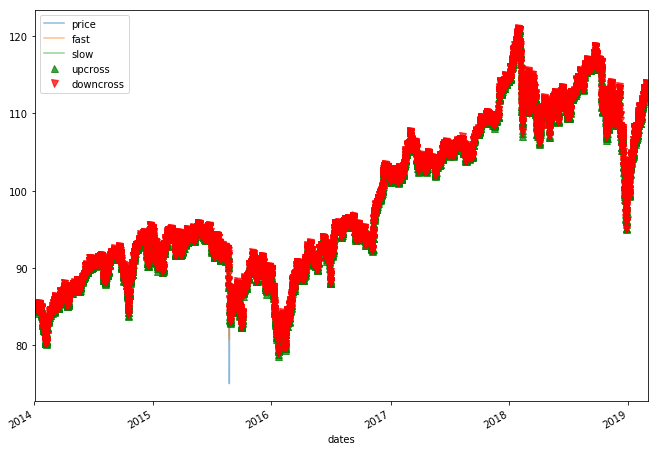

In [18]:
import matplotlib.pyplot as plt

close_df = crossover.close_df(close, fast_window, slow_window)
up = crossover.get_up_cross(close_df)
down = crossover.get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

Label features with triple barrier method (does the price goes up down within a defined time).

In [19]:
tEvents = labeller.getTEvents(close_df['price'], h=dailyVol.mean())
t1 = labeller.addVerticalBarrier(tEvents, close_df['price'], numDays=1)

target = dailyVol

# Run in single-threaded mode on Windows

if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1

minRet = .01 
ptsl=[1, 2]

ma_events = labeller.getEvents(close_df['price'], tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)

ma_side = ma_events.dropna().side
ma_bins = labeller.getBinsNew(ma_events, close_df['price'], t1).dropna()

Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')

data_processed_dir = data_dir / 'processed'
parq_file_name = file_name + '_crossover_train_test.parq'

outfp = PurePath(data_processed_dir / parq_file_name)

Xx.to_parquet(outfp)



100%|██████████| 500801/500801 [00:42<00:00, 11799.42it/s]


AttributeError: 'tuple' object has no attribute 'loc'

In [ ]:
ma_events.side.value_counts()


Learn the size of the trade.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from src.utils.utils import get_relative_project_dir, cprint


RANDOM_STATE = 777
#training data
X = Xx.side.values.reshape(-1,1)
#labels
y = Xx.bin.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy')

rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
